# Multi-scale RAG for CVPR2024 papers

Notebook created by Ignacio Sarasua (isarasua@nvidia.com) to showcase how to run a RAG pipeline at different scales.
In the first scale, we define a RAG pipeline that can read from all the abstracts from CVPR2024, so we can observe general trends, as well as, identify interesting papers for us.
In the second scale, we can select a single paper in which we would like to run RAG on. This allows us to get more details about that single papers.
Note: This is an illustrative (vanilla) example, designed as a starting point for more complex architectures. It could also be adapted to other conferences and/or databases
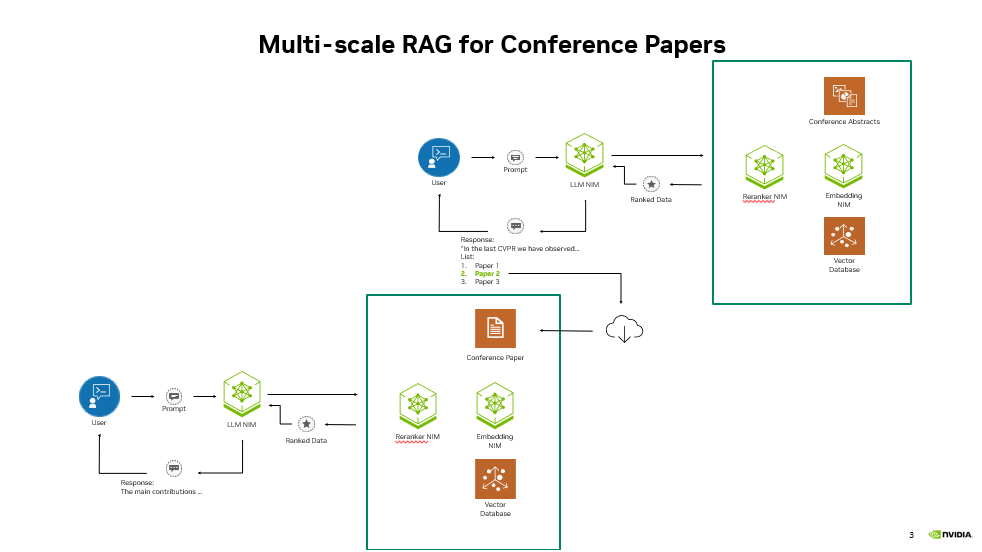

In [1]:
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings
from langchain.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader, TextLoader
import os

First we need to set our NV enpoint API key. More info in ai.nvidia.com, and select which models we are going to use for the RAG pipeline. In total there will be three models:
1. embedding_model: It will be in charge of creating the embeddings given a set of characters
2. model_qa: this will be the LLM that the user will interact with (chatbot)
3. model_retrieval: this is the model that will interact with the retrieval pipeline.

In [2]:
import getpass
if not os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    nvapi_key = getpass.getpass("Enter your NVIDIA API key: ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key 
#ChatNVIDIA.get_available_models()  # Uncomment for checking the list of supported models

Enter your NVIDIA API key:  ········


In [3]:
## IMPORTANT: Check these endpoints are still available at build.nvidia.com 
embedding_model = NVIDIAEmbeddings(model="nvidia/llama-3.2-nv-embedqa-1b-v2")
llm_qa = ChatNVIDIA(model="meta/llama-3.1-70b-instruct")
llm_retrieval = ChatNVIDIA(model="meta/llama-3.1-70b-instruct")

Download the abstracts (if necessary)

In [4]:
abstract_path = "./CVPR2024_abstracts"
if not os.path.exists(abstract_path):
    from utils import download_abstracts
    download_abstracts(npapers=100)

Found 2716 paper titles
Fetching abstract for: Unmixing Diffusion for Self-Supervised Hyperspectral Image Denoising
Saved abstract: CVPR2024_abstracts\Unmixing Diffusion for Self-Supervised Hyperspectral Image Denoising.txt
Fetching abstract for: Seeing the World through Your Eyes
Saved abstract: CVPR2024_abstracts\Seeing the World through Your Eyes.txt
Fetching abstract for: DPMesh: Exploiting Diffusion Prior for Occluded Human Mesh Recovery
Saved abstract: CVPR2024_abstracts\DPMesh_ Exploiting Diffusion Prior for Occluded Human Mesh Recovery.txt
Fetching abstract for: Ungeneralizable Examples
Saved abstract: CVPR2024_abstracts\Ungeneralizable Examples.txt
Fetching abstract for: LaneCPP: Continuous 3D Lane Detection using Physical Priors
Saved abstract: CVPR2024_abstracts\LaneCPP_ Continuous 3D Lane Detection using Physical Priors.txt
Fetching abstract for: CityDreamer: Compositional Generative Model of Unbounded 3D Cities
Saved abstract: CVPR2024_abstracts\CityDreamer_ Compositional 

Generate Embeddings (if necessary)

In [5]:
def create_embeddings(docs_dir,embedding_path="./embed_abstracts_m7b2",embeddings=embedding_model):
    print(f"Storing embeddings to {embedding_path}")
    pages_all = []
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=512, chunk_overlap=10, separators=[" ", ",", "\n"]
        )
    for path in os.listdir(docs_dir):
        #print(path)
        try:
            loader = TextLoader(docs_dir+"/"+ path)
            pages_all += loader.load_and_split(text_splitter=text_splitter)
        except:
            print("not found")
            continue
    print(len(pages_all))
    faiss_index = FAISS.from_documents(pages_all, embedding=embeddings)
    faiss_index.save_local(folder_path=embedding_path)
    print("Generated embedding successfully")

### First scale RAG
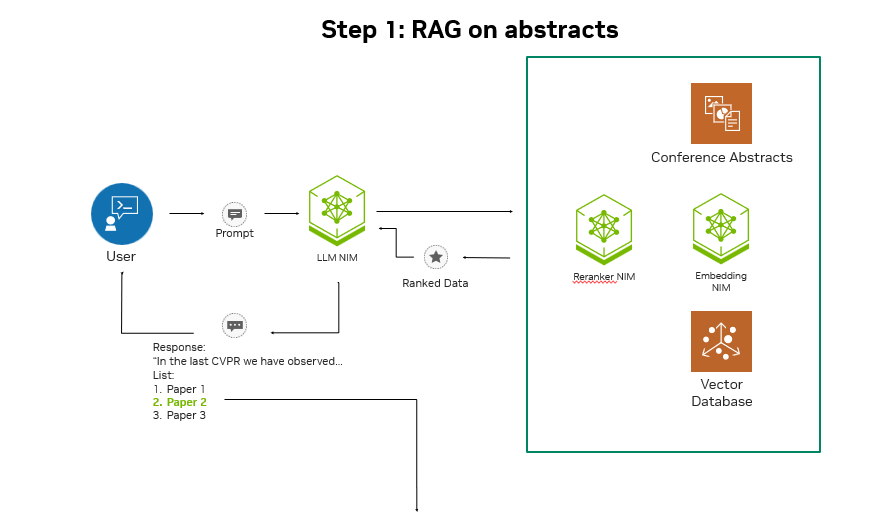

In [6]:
embedding_path="./embed_abstracts_e5/"
if not os.path.isfile(embedding_path + "/index.faiss"):
    create_embeddings(docs_dir=abstract_path,embedding_path=embedding_path,embeddings=embedding_model)

Storing embeddings to ./embed_abstracts_e5/
300
Generated embedding successfully


Load embeddings and initialize the retriever

In [7]:
docsearch = FAISS.load_local(folder_path=embedding_path, embeddings=embedding_model,allow_dangerous_deserialization=True)
retriever = docsearch.as_retriever(search_kwargs={'k': 40})
#retriever = docsearch.as_retriever()

Adding Rerank NIM

In [8]:
k = 20
from langchain.retrievers import ContextualCompressionRetriever
from langchain_nvidia_ai_endpoints import NVIDIARerank
compressor = NVIDIARerank(model="nvidia/llama-3.2-nv-rerankqa-1b-v1",top_n=k,truncate="END")
retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=retriever
)

Create retrieval and Q&A chains (with their corresponding prompts)

In [9]:
### Contextualize question ###
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm_retrieval, retriever, contextualize_q_prompt
)


### Answer question ###
system_prompt = (
    "You are an assistant for a researcher"
    "The questions asked are going to be related to a group of abstracts of papers published at a CVPR2024."
    "Use the following pieces of retrieved context to answer.  If you don't know the answer, say that you "
    "don't know. IMPORTANT: Always answer in the language the question was asked in."
    "\n\n"
    "{context}"
)
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm_qa, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)


Add memory to the chatbot, so it can answer follow-up questions

In [10]:
### Statefully manage chat history ###
store = {}


def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]


conversational_rag_chain_abstracts = RunnableWithMessageHistory(
    rag_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)

Now let's test the Reranking model. We first invoke the chain (forward throught the whole pipeline)

In [11]:
result=conversational_rag_chain_abstracts.invoke(
    {"input": "Can you tell me how LLMs are being used in CVPR?"},
    config={
        "configurable": {"session_id": "abc123"}
    },  # constructs a key "abc123" in `store`.
)

Visualize the response from the LLM

In [12]:
print(result["answer"])

Based on the provided abstracts from CVPR 2024, here are some ways Large Language Models (LLMs) are being utilized in Computer Vision (CV) research, as evident from the papers:

1. **Video Summarization**:
	* As **Oracle summarizers** to generate large-scale video summarization datasets (Abstract 1).
	* To analyze limitations of existing approaches and propose new video summarization models (Abstract 1).
	* To improve video summarization across several benchmarks (Abstract 13).
2. **Autonomous Vehicles and Safety-Critical Scenarios**:
	* **ChatScene**: Leveraging LLMs to generate textually described traffic scenarios for autonomous vehicles, which are then transformed into detailed specifications (Abstract 2).
3. **Image Restoration and Enhancement**:
	* Exploring the potential of pre-trained LLMs (like CLIP, Stable Diffusion) for low-level tasks such as image restoration, enhancing their off-the-shelf features for this purpose (Abstract 3).
4. **Instruction-aware Tasks and Bird's-Eye-

Check which abstracts were more relevant to answer that question according to the NVIDIA Rerank NIM

In [13]:
papers = []
for i in range(len(result['context'])):
    print(result['context'][i].metadata['source'][21:-4])
    print(result['context'][i].metadata["relevance_score"])
    papers.append(result['context'][i].metadata['source'][21:-4])

Scaling Up Video Summarization Pretraining with Large Language Models
-0.7998046875
ChatScene_ Knowledge-Enabled Safety-Critical Scenario Generation for Autonomous Vehicles
-1.509765625
Boosting Image Restoration via Priors from Pre-trained Models
-1.8037109375
Scaling Up Video Summarization Pretraining with Large Language Models
-1.8857421875
Holistic Autonomous Driving Understanding by Bird's-Eye-View Injected Multi-Modal Large Models
-2.056640625
MeaCap_ Memory-Augmented Zero-shot Image Captioning
-2.162109375
Holistic Autonomous Driving Understanding by Bird's-Eye-View Injected Multi-Modal Large Models
-2.162109375
PRDP_ Proximal Reward Difference Prediction for Large-Scale Reward Finetuning of Diffusion Models
-2.38671875
Decomposing Disease Descriptions for Enhanced Pathology Detection_ A Multi-Aspect Vision-Language Pre-training Framework
-2.423828125
Programmable Motion Generation for Open-Set Motion Control Tasks
-2.5078125
PRDP_ Proximal Reward Difference Prediction for Large

### Second scale RAG
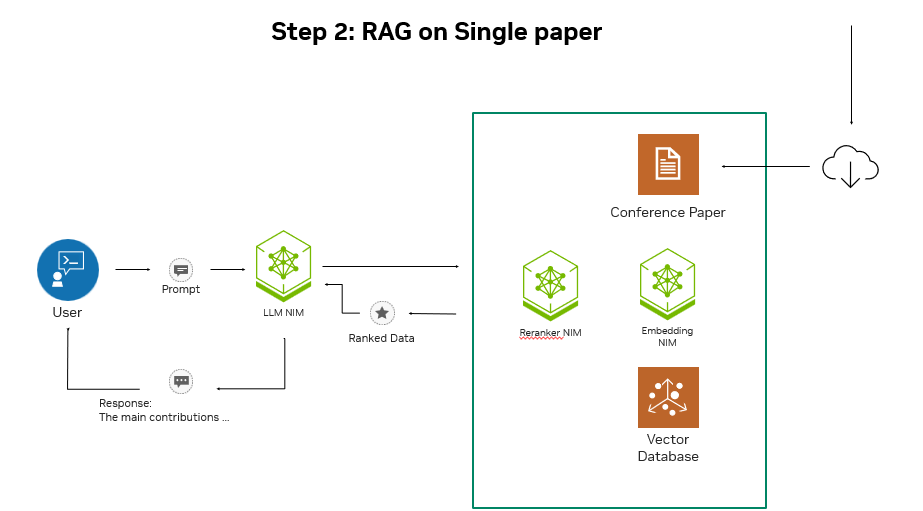

Here, we can select which paper we would like to analyze more in detail (i.e. next scale of the RAG)

In [14]:
print("Select which of the relevant papers you want to explore in detail:")
for i,paper in enumerate(papers):
    print(str(i) + ". " + paper)
paper_idx = int(input("Paper index"))
print(papers[paper_idx])

Select which of the relevant papers you want to explore in detail:
0. Scaling Up Video Summarization Pretraining with Large Language Models
1. ChatScene_ Knowledge-Enabled Safety-Critical Scenario Generation for Autonomous Vehicles
2. Boosting Image Restoration via Priors from Pre-trained Models
3. Scaling Up Video Summarization Pretraining with Large Language Models
4. Holistic Autonomous Driving Understanding by Bird's-Eye-View Injected Multi-Modal Large Models
5. MeaCap_ Memory-Augmented Zero-shot Image Captioning
6. Holistic Autonomous Driving Understanding by Bird's-Eye-View Injected Multi-Modal Large Models
7. PRDP_ Proximal Reward Difference Prediction for Large-Scale Reward Finetuning of Diffusion Models
8. Decomposing Disease Descriptions for Enhanced Pathology Detection_ A Multi-Aspect Vision-Language Pre-training Framework
9. Programmable Motion Generation for Open-Set Motion Control Tasks
10. PRDP_ Proximal Reward Difference Prediction for Large-Scale Reward Finetuning of D

Paper index 2


Boosting Image Restoration via Priors from Pre-trained Models


Define a function to download a paper from openaccess given the set title

In [15]:
from utils import download_paper
import requests

def download_embed_cvpr_paper(paper_title,embeddings=embedding_model):
    try:
        #download document
        filename = download_paper(paper_title, base_url = "https://openaccess.thecvf.com/CVPR2024?day=all")
        #generate embeddings
        print(embeddings)
        loader = PyPDFLoader(filename)
        text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=512, chunk_overlap=10, separators=[" ", ",", "\n"]
        )
        pages_all = loader.load_and_split(text_splitter=text_splitter)
        return FAISS.from_documents(pages_all, embedding=embeddings)

    except requests.RequestException as e:
        print(f"An error occurred: {e}")
    



Download and create embeddings for the selected paper

In [16]:
docsearch_paper = download_embed_cvpr_paper(papers[paper_idx])

CVPR_papers\Boosting Image Restoration via Priors from Pre-trained Models.pdf
Successfully downloaded 'CVPR_papers\Boosting Image Restoration via Priors from Pre-trained Models.pdf'
base_url='https://integrate.api.nvidia.com/v1' model='nvdev/nvidia/nv-embedqa-e5-v5' truncate='START' max_batch_size=50


We created an advanced version of the UI (more code in ui_grad.py file) to unify the previous steps into a single UI

Let's define a similar chain for the downloaded paper. We can use the same compressor as above:

In [17]:
#compressor = NVIDIARerank(model="nvidia/nv-rerankqa-mistral-4b-v3") #Uncomment if you want to change the reranking model
retriever_paper = docsearch_paper.as_retriever(search_kwargs={'k': 20})

In [18]:
retriever_paper = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=retriever_paper
)

We define the propmts 

In [19]:
## Contextualize question  ###
contextualize_q_system_prompt_paper = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)
contextualize_q_prompt_paper = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt_paper),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever_paper = create_history_aware_retriever(
    llm_retrieval, retriever_paper, contextualize_q_prompt_paper
)

In [20]:
### Answer question ###
system_prompt_paper = (
    "You are an assistant for a researcher. The knowledge base you have is a paper published at CVPR and stored in the file"
    "The questions asked are going to be related to the paper previously mentioned and provided in the context. Everytime they refer to a paper you can assume they are speaking to the one provided in this contex"
    "Use the following pieces of retrieved context to answer.  If you don't know the answer, say that you "
    "don't know. IMPORTANT: Always answer in the language the question was asked in."
    "\n\n"
    "{context}"
)
qa_prompt_paper = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_paper),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
question_answer_chain_paper = create_stuff_documents_chain(llm_qa, qa_prompt_paper)

rag_chain_paper = create_retrieval_chain(history_aware_retriever_paper, question_answer_chain_paper)

In [21]:
store = {}

conversational_rag_chain_paper = RunnableWithMessageHistory(
    rag_chain_paper,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)

In [22]:
result=conversational_rag_chain_paper.invoke(
    {"input": "Can you summaize this work?"},
    config={
        "configurable": {"session_id": "123abc"}
    },  # constructs a key "abc123" in `store`.
)

In [23]:
print(result["answer"])

Based on the provided context, here is a summary of the work:

**Title:** (Not explicitly mentioned in the provided context, but related to Image Enhancement/Restoration)

**Key Contributions:**

1. **Lightweight Refinement Module**: The authors propose a lightweight refinement module (< 1M parameters) that can be added to existing image restoration models to enhance their performance.
2. **Pre-Trained Guided Spatial-Varying Operations (PTG-SVE)**: A novel approach that utilizes pre-trained features to guide spatial-varying operations, adapting to different pixel qualities.
3. **Learned Score Range Map**: Instead of relying on pre-computed SNR values, the method learns a score range map online to decide the optimal operation range for each pixel.

**Methodology:**

* The refinement module consists of PTG-SVE and Pre-Trained Guided Channel-Spatial Attention (PTG-CSA) components.
* The learned score range map is used to merge short- and long-range features.
* The final enhanced image is 

Trying agents.
First we will define a new chain that combines both knowledge bases.

In [24]:
from langchain.retrievers import EnsembleRetriever

combined_retriever = EnsembleRetriever(
    retrievers=[retriever_paper, retriever],
    weights=[0.7, 0.3]  # Assign higher weight to paper context
)

contextualize_q_system_prompt_combined = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)
contextualize_q_prompt_combined = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt_combined),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever_combined = create_history_aware_retriever(
    llm_retrieval, combined_retriever, contextualize_q_prompt_combined
)

In [25]:
paper_title = papers[paper_idx]
paper_title

'Boosting Image Restoration via Priors from Pre-trained Models'

In [26]:
### Answer question ###
system_prompt_combined = f"""You are an assistant for a researcher analyzing computer vision papers. Your knowledge base is composed by two sources of information:
A specific CVPR paper titled "{paper_title}" (Source 1): This is the main paper being analyzed. You have been provided with the whole article in the context.
A collection of CVPR abstracts (Source 2): These provide broader context from the conference.
When answering questions:
For Source 1 (main paper "{paper_title}"), provide detailed analysis and specific information
For Source 2 (abstracts), use it to provide context, comparisons, and identify related work
When comparing, explicitly mention whether insights come from the main paper "{paper_title}" or other conference papers
If you don't know the answer or can't find relevant information in either source, please say so.
IMPORTANT: Always answer in the language the question was asked in.
{{context}}"""
qa_prompt_combined = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_combined),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
question_answer_chain_combined = create_stuff_documents_chain(llm_qa, qa_prompt_combined)

rag_chain_combined = create_retrieval_chain(history_aware_retriever_combined, question_answer_chain_combined)


store = {}

conversational_rag_chain_combined = RunnableWithMessageHistory(
    rag_chain_combined,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)

In [27]:

#let's test the chain
result = conversational_rag_chain_combined.invoke(
    {
        "input": "Can you give explain the paper and compare it to the abstracts in the database?",
    },
    config={
        "configurable": {"session_id": "001"}
    }
)

print(result["answer"])

I'll provide an explanation of the paper "Boosting Image Restoration via Priors from Pre-trained Models" and compare it to related work from the abstracts in the database (Source 2).

**Explanation of the Paper (Source 1):**

**Title:** Boosting Image Restoration via Priors from Pre-trained Models
**Main Contribution:** The paper proposes a method to enhance image restoration tasks (e.g., deraining, deblurring, denoising) by leveraging priors from pre-trained models. These priors are extracted without requiring explicit annotations.

**Key Components:**

1. **Pre-trained Model Selection:** The authors utilize pre-trained models with various training objectives, such as CLIP, BLIP, BLIP2, and restoration models (e.g., trained on large-scale data).
2. **Prior Extraction:** Degradation-related information is extracted from the selected pre-trained models. This is done by exposing these models to different degradations during pre-training.
3. **Lightweight Refinement Module:** A small refi

In [28]:
for i in range(len(result['context'])):
    print(result['context'][i].metadata['source'][21:-4])
    print(result['context'][i].metadata["relevance_score"])
    papers.append(result['context'][i].metadata['source'][21:-4])

Image Restoration via Priors from Pre-trained Models
-2.951171875
Image Restoration via Priors from Pre-trained Models
-3.34765625
Image Restoration via Priors from Pre-trained Models
-3.349609375
Image Restoration via Priors from Pre-trained Models
-3.3671875
Image Restoration via Priors from Pre-trained Models
-3.39453125
Image Restoration via Priors from Pre-trained Models
-3.40625
Image Restoration via Priors from Pre-trained Models
-3.5859375
Image Restoration via Priors from Pre-trained Models
-3.615234375
Image Restoration via Priors from Pre-trained Models
-3.625
Image Restoration via Priors from Pre-trained Models
-3.70703125
Image Restoration via Priors from Pre-trained Models
-3.724609375
Image Restoration via Priors from Pre-trained Models
-3.75390625
Image Restoration via Priors from Pre-trained Models
-3.794921875
Image Restoration via Priors from Pre-trained Models
-3.828125
Image Restoration via Priors from Pre-trained Models
-3.91796875
Image Restoration via Priors fro

![ms_rag_agent](MS_Agentic_RAG.png)

In [29]:
abstract_chain = rag_chain
paper_chain = rag_chain_paper
combined_chain = rag_chain_combined
llm = ChatNVIDIA(model="nvdev/nvidia/llama-3.1-nemotron-70b-instruct")

In [31]:
from langgraph.graph import START, END, StateGraph
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, FunctionMessage
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

In [33]:

# State definition
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]  # Correct annotation
    next_step: str
    final_answer: str
    
llm = ChatNVIDIA(model="nvidia/llama-3.1-nemotron-70b-instruct")


def route_query(state):
    router_prompt = """Given a user query, determine which knowledge base to search:
    - 'abstract' for conference abstract database. Choose this option every time you detect a more generic question about the conference. e.g. what are some trends we observe at the conference?
    - 'paper' for insights about the particular paper that is in this database. E.g. What are the main contributions of this paper?
    - 'both' if both sources should be consulted for comparing the paper with the general context of the conference. E.g. How do the results of this work compare with some other related articles at the conference?
    
    Query: {query}
    
    Respond only with: abstract, paper, or both"""
    
    query = state["messages"][-1].content
    response = llm.invoke(router_prompt.format(query=query))
    return {"next_step": response.content.strip()}

In [34]:
def query_abstracts(state):
    query = state["messages"][-1].content
    results = abstract_chain.invoke({
        "input": query,
        "chat_history": [],
        "context": ""
    })
    return {
        "messages": state["messages"],
        "next_step": state["next_step"],
        "final_answer": results
    }

def query_paper(state):
    query = state["messages"][-1].content
    results = paper_chain.invoke({
        "input": query,
        "chat_history": [],
        "context": ""
    })
    return {
        "messages": state["messages"],
        "next_step": state["next_step"],
        "final_answer": results
    }
def both_queries(state):
    query = state["messages"][-1].content
    results = combined_chain.invoke({
        "input": query,
        "chat_history": [],
        "context": ""
    })
    return {
        "messages": state["messages"],
        "next_step": state["next_step"],
        "final_answer": results
    }
    


def final_results(state):
    final = f"Chain choice: {state['next_step']}\n\n Final answer: {state['final_answer']}"
    return {
        "messages": state["messages"] + [FunctionMessage(
            content=final,
            name="final_results"  # Add the required name parameter
        )]
    }



In [35]:
# Create workflow graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("route", route_query)
workflow.add_node("query_abstracts", query_abstracts)
workflow.add_node("query_paper", query_paper)
workflow.add_node("both_queries", both_queries)
workflow.add_node("final", final_results)

# Add entry point
workflow.add_edge(START, "route")

# Add conditional edges
workflow.add_conditional_edges(
    "route",
    lambda x: x["next_step"],
    {
        "abstract": "query_abstracts",
        "paper": "query_paper",
        "both": "both_queries"
    }
)

# Add remaining edges
workflow.add_edge("query_abstracts", "final")
workflow.add_edge("query_paper", "final")
workflow.add_edge("both_queries", "final")
workflow.add_edge("final", END)


# Compile the graph
agent = workflow.compile()

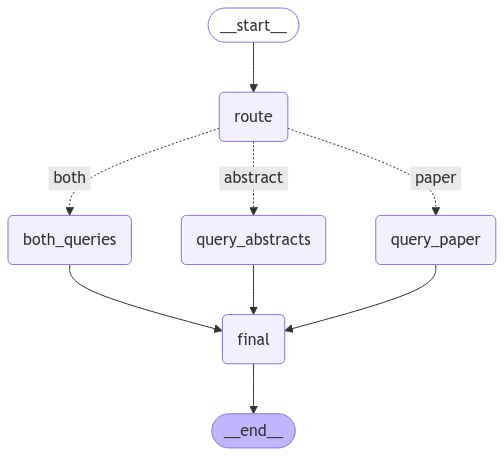

In [36]:
from IPython.display import Image, display

try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [37]:
from langchain_core.messages import HumanMessage

response = agent.invoke({
    "messages": [HumanMessage(content="Can you  explain the paper ?")],
    "next_step": "route",
    "final_answer": ""
})

In [38]:
response

{'messages': [HumanMessage(content='Can you  explain the paper ?', additional_kwargs={}, response_metadata={}, id='78984478-0c6f-4f77-9b5c-ed2fd863c064'),
  FunctionMessage(content='Chain choice: paper\n\n Final answer: {\'input\': \'Can you  explain the paper ?\', \'chat_history\': [], \'context\': [Document(metadata={\'source\': \'CVPR_papers\\\\Boosting Image Restoration via Priors from Pre-trained Models.pdf\', \'page\': 5, \'relevance_score\': -0.9501953125}, page_content=\'improve-\\nment for a given target model. Notably, the improvements\\nachieved by other methods are based on large additional pa-\\nrameters, while our approach only uses a lightweight refine-\\nment module< 1M.\\nAblation Study: Ablation of Different Components. We\\nfirst set experiments by deleting different components from\\nour framework, including PTG-SVE (abbreviated as “SP”),\\nand spatial-channel attentions with priors that are abbrevi-\\nInput\\n Ground-truth\\nRestormer\\n Restormer+Ours\\nFigure 5. 

In [39]:
from ui_utils import ConferenceAnalysisInterface

# Assuming you have your agent already defined
# from your_agent_module import agent

# Create the interface
interface = ConferenceAnalysisInterface(agent)

# Launch the interface
interface.launch()

C:\Users\isarasua\AppData\Local\anaconda3\envs\python_310_testPB\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
